In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

drive_folder_path = '/content/drive/My Drive/Scientific_data_analysis'
os.chdir(drive_folder_path)


In [ ]:
import pandas as pd
import numpy as np

def process_file(file_path, currency, convert_to_euro=False):
    df = pd.read_csv(file_path)

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    columns_to_keep = ['Close']
    for col in columns_to_keep:
        df[col] = df[col].replace(',', '', regex=True).astype(float)

        if convert_to_euro:
            df[col] = df[col] * 0.92

    df = df[columns_to_keep].fillna(method='ffill')

    df.columns = [f"{col}_{currency}" for col in columns_to_keep]

    return df

file_paths = {
    'ETH-EUR.csv': ('ETH', False),
    'BTC-EUR.csv': ('BTC', False),
    'DOGE-EUR.csv': ('DOGE', False),
    'USDT-EUR.csv': ('USDT', False),
    'XRP-EUR.csv': ('XRP', False),
    'S&P.csv': ('SP', True),  # Convert to Euro
    'Gold.csv': ('Gold', True),  # Convert to Euro
    'Apple.csv': ('Apple', True),  # Convert to Euro
    'Nasdaq.csv': ('Nasdaq', True),  # Convert to Euro
    'Silver.csv': ('Silver', True),  # Convert to Euro
    'Oil.csv': ('Oil', True),  # Convert to Euro
    'ADA-EUR.csv': ('ADA', False)
}


dataframes = {}
for file, (code, convert_to_euro) in file_paths.items():
    df_processed = process_file(file, code, convert_to_euro)
    dataframes[code] = df_processed

combined_df = pd.concat(dataframes.values(), axis=1)

def clean_data(df):
    if df.isna().any().any() or np.isinf(df).any().any():
        df = df.ffill().bfill()

        df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

df_clean = clean_data(combined_df)
print(df_clean.head())

            Close_ETH  Close_BTC  Close_DOGE  Close_USDT  Close_XRP  \
Date                                                                  
2021-12-03    3740.07    16670.0    0.098535      0.9493     0.3713   
2021-12-04    3599.83    16670.0    0.098535      0.9493     0.3713   
2021-12-05    3672.30    16670.0    0.098535      0.9493     0.3713   
2021-12-06    3832.43    16670.0    0.098535      0.9493     0.3713   
2021-12-07    3809.00    16670.0    0.098535      0.9493     0.3713   

             Close_SP  Close_Gold  Close_Apple  Close_Nasdaq  Close_Silver  \
Date                                                                         
2021-12-03  3678.9328    1638.796     134.8996    10340.7448      20.62364   
2021-12-04  3678.9328    1638.796     134.8996    10340.7448      20.62364   
2021-12-05  3678.9328    1638.796     134.8996    10340.7448      20.62364   
2021-12-06  3678.9328    1638.796     134.8996    10340.7448      20.62364   
2021-12-07  3678.9328    1638.796 

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

df_clean.fillna(method='bfill', inplace=True)

eth_close = df_clean[['Close_ETH']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
eth_scaled = scaler.fit_transform(eth_close)


def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)


time_step = 10


X, y = create_dataset(eth_scaled, time_step)


X = X.reshape(X.shape[0], X.shape[1], 1)

# Define the train/test split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

# Split the data into training and test sets
X_train, X_test = X[0:train_size,:,:], X[train_size:len(X),:,:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]


Epoch 1/100
18/18 [==============================] - 6s 95ms/step - loss: 0.0306 - val_loss: 7.3380e-04
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0050 - val_loss: 4.7085e-04
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0030 - val_loss: 5.8190e-04
Epoch 4/100
18/18 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 6.8080e-04
Epoch 5/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0029 - val_loss: 5.2230e-04
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 5.4662e-04
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0029 - val_loss: 4.0943e-04
Epoch 8/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 3.9683e-04
Epoch 9/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 6.7073e-04
Epoch 10/100
18/18 [==============================] - 0s 18ms/st

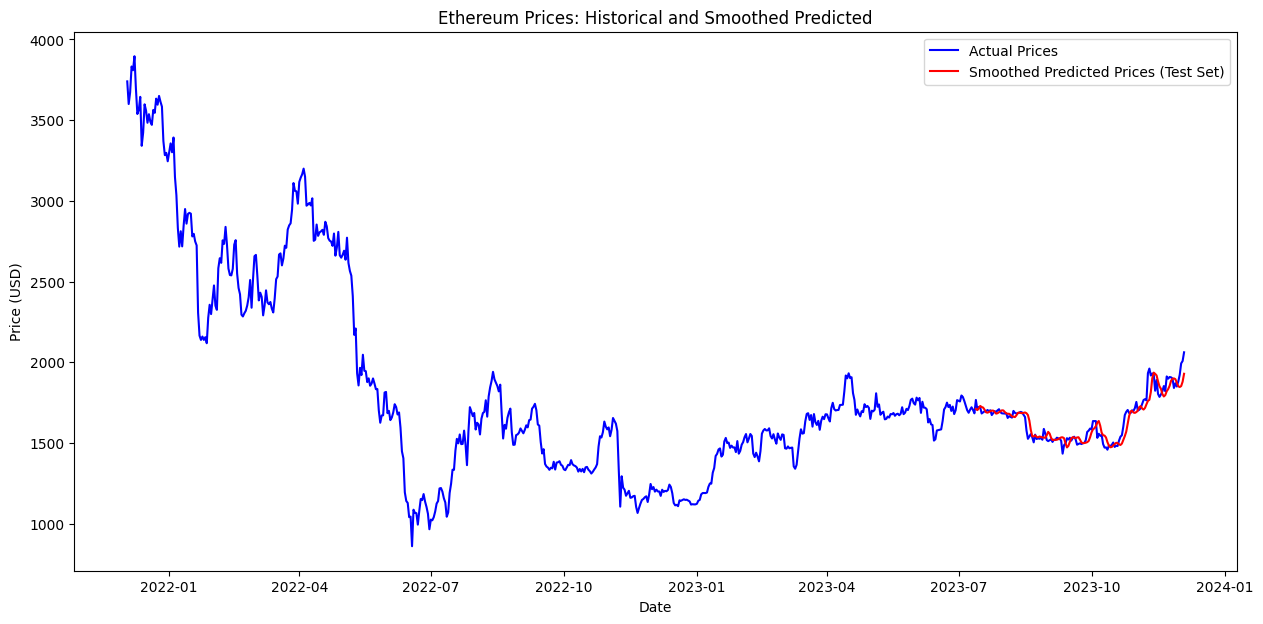

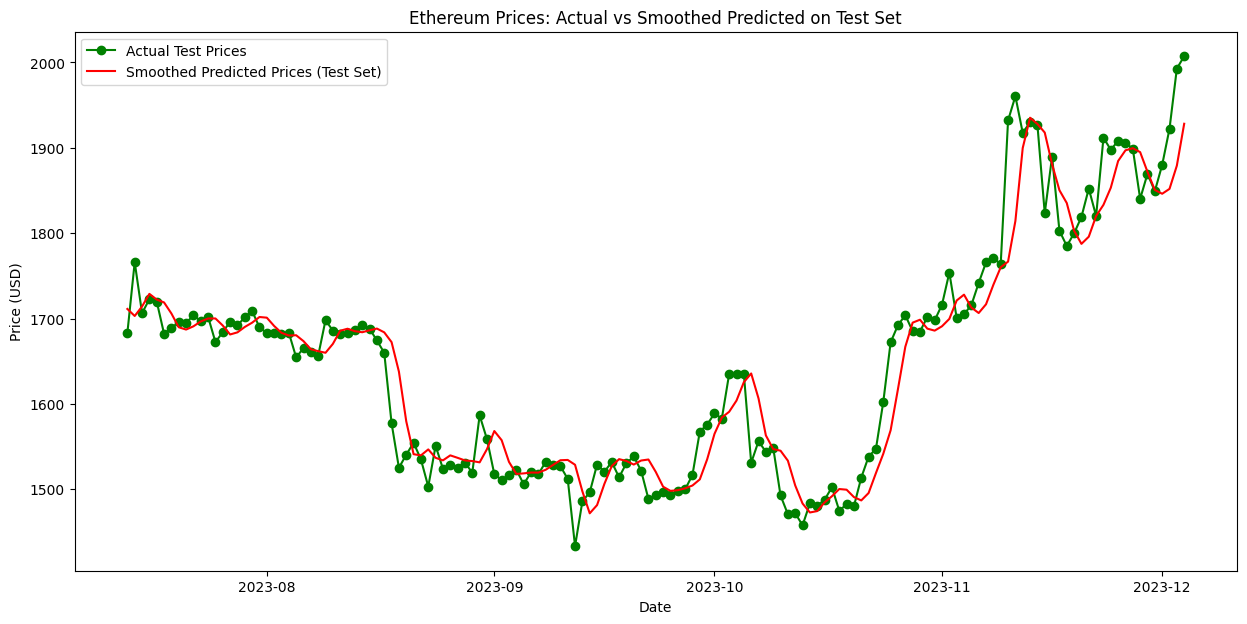

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model using the training set and validate on the test set
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=32, epochs=100, verbose=1, callbacks=[early_stopping])


# Predict on the test set
test_predict = model.predict(X_test)

# Inverse transform to get actual values for the test set
test_predict = scaler.inverse_transform(test_predict)
actual_prices_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, and MSE for the test set
test_rmse = np.sqrt(mean_squared_error(actual_prices_test, test_predict))
test_mae = mean_absolute_error(actual_prices_test, test_predict)
test_mse = mean_squared_error(actual_prices_test, test_predict)

# Performance metrics
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')


predicted_index = df_clean.index[-len(test_predict):]

# Apply a rolling mean to smooth the predictions
window_size = 2
smoothed_predictions = pd.Series(test_predict.flatten(), index=predicted_index).rolling(window=window_size, min_periods=1).mean()

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

# First Graph: Plot of the whole closing ETH prices which is split into actual and predicted
plt.figure(figsize=(15, 7))
plt.plot(df_clean.index, df_clean['Close_ETH'], label='Actual Prices', color='blue')

predicted_index = df_clean.index[-len(test_predict):]

# Plot of the smoothed predicted prices on top of the actual prices
plt.plot(predicted_index, smoothed_predictions, label='Smoothed Predicted Prices (Test Set)', color='red', linestyle='-')
plt.title('Ethereum Prices: Historical and Smoothed Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Second Graph: Plot of the actual and smoothed predicted prices for the test set
plt.figure(figsize=(15, 7))
plt.plot(df_clean.index[-len(actual_prices_test):], actual_prices_test, label='Actual Test Prices', color='green', marker='o')

# Plot the smoothed predictions
plt.plot(predicted_index, smoothed_predictions, label='Smoothed Predicted Prices (Test Set)', color='red', linestyle='-')

plt.title('Ethereum Prices: Actual vs Smoothed Predicted on Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
